In [161]:
import music21
import numpy as np
import pypianoroll
import os
from PIL import Image
from matplotlib import pyplot as plt 

In [162]:
from tensorflow import keras

from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten,BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from IPython.display import clear_output

## Function to convert MIDI files to images

In [159]:
from music21 import converter, instrument, note, chord
import sys
import numpy as np
from imageio import imwrite

def extractNote(element):
    return int(element.pitch.ps)

def extractDuration(element):
    return element.duration.quarterLength

def get_notes(notes_to_parse):

    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    durations = []
    notes = []
    start = []

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            if element.isRest:
                continue

            start.append(element.offset)
            notes.append(extractNote(element))
            durations.append(extractDuration(element))
                
        elif isinstance(element, chord.Chord):
            if element.isRest:
                continue
            for chord_note in element:
                start.append(element.offset)
                durations.append(extractDuration(element))
                notes.append(extractNote(chord_note))

    return {"start":start, "pitch":notes, "dur":durations}


def midi2image(midi_path, max_repetitions = float("inf"), resolution = 0.25, lowerBoundNote = 21, upperBoundNote = 127, maxSongLength = 100):
    mid = converter.parse(midi_path)

    instruments = instrument.partitionByInstrument(mid)

    data = {}

    try:
        i=0
        for instrument_i in instruments.parts:
            notes_to_parse = instrument_i.recurse()

            notes_data = get_notes(notes_to_parse)
            if len(notes_data["start"]) == 0:
                continue

            if instrument_i.partName is None:
                data["instrument_{}".format(i)] = notes_data
                i+=1
            else:
                data[instrument_i.partName] = notes_data

    except:
        notes_to_parse = mid.flat.notes
        data["instrument_0"] = get_notes(notes_to_parse)

    for instrument_name, values in data.items():
        # https://en.wikipedia.org/wiki/Scientific_pitch_notation#Similar_systems

        pitches = values["pitch"]
        durs = values["dur"]
        starts = values["start"]

        index = 0
        while index < max_repetitions:
            matrix = np.zeros((upperBoundNote-lowerBoundNote,maxSongLength))


            for dur, start, pitch in zip(durs, starts, pitches):
                dur = int(dur/resolution)
                start = int(start/resolution)

                if not start > index*(maxSongLength+1) or not dur+start < index*maxSongLength:
                    for j in range(start,start+dur):
                        if j - index*maxSongLength >= 0 and j - index*maxSongLength < maxSongLength:
                            matrix[pitch-lowerBoundNote,j - index*maxSongLength] = 255

            if matrix.any(): # If matrix contains no notes (only zeros) don't save it
                imwrite('C:\masters\DLIV\lstm_midi_images\\'+midi_path.split("\\")[-1].replace(".mid",f"_{instrument_name}_{index}.png"),matrix.astype(np.uint8))
                index += 1
            else:
                break

# if __name__ == "__main__":
#     midi_path = sys.argv[1]

#     if len(sys.argv) >= 3:
#         max_repetitions = int(sys.argv[2])
#         midi2image(midi_path, max_repetitions)
#     else:
#         midi2image(midi_path)

## Loading MIDI files and converting them to images

In [164]:
midi_path_strings = []

## Two dataset, one for Classical and one for fantasy music
path = 'C:\Projects\DLIV\Classical-Piano-Composer-master\Fantasy'
path = 'C:\masters\DLIV\Classical-Piano-Composer-master\Classical'

midis = os.listdir(path)
for midi in midis:
    midi_path_strings.append(path+'\\'+midi)

for midi_path_string in midi_path_strings:
    midi2image(midi_path_string)

In [167]:

path = 'C:\masters\DLIV\\chopin_midi_images'
img_list = os.listdir(path)
for midim in img_list:
    img = Image.open(path +"\\"+ midim)
    img = img.resize((106,106), Image.ANTIALIAS)
    img.save(path + "\\" +  midim)
    

C:\Users\Heinz\AppData\Local\Temp\ipykernel_23228\803201062.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((106,106), Image.ANTIALIAS)


## Loading the converted images for model training

In [168]:
path = 'C:\masters\DLIV\midi_images'
path = 'C:\masters\DLIV\\chopin_midi_images'
path_fantasy = 'C:\masters\DLIV\\fantasy_midi_images'
img_list = os.listdir(path)
fant_img_list = os.listdir(path_fantasy)
def access_images(img_list,path,length):
    pixels = []
    imgs = []
    for i in range(length):
        if 'png' in img_list[i]:
            img = Image.open(path+'/'+img_list[i],'r')
            img = img.convert('1')
            pix = np.array(img.getdata())
            pix = pix.astype('float32')
            pix /= 255.0
            pixels.append(pix.reshape(106,106,1))
            imgs.append(img)
            # print(img.size)
            # pixels.append(s.reshape(106,106,1))
            # imgs.append(img)
    return np.array(pixels),imgs
def show_image(pix_list):
    array = np.array(pix_list.reshape(103,103), dtype=np.uint8)
    new_image = Image.fromarray(array)
    new_image.show()
    
pixels,imgs = access_images(img_list,path,len(img_list))
pixels_fant,imgs_fant = access_images(fant_img_list,path_fantasy,len(img_list))

In [169]:
len(imgs)

4189

In [170]:
path = 'C:\\masters\\DLIV\\midi_images\\'
img_list = os.listdir(path)

# GAN, defining the discriminator and the generator

In [171]:
def define_discriminator(in_shape = (106,106,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 53 * 53
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((53, 53, 128)))
    model.add(Dense(1024))
    model.add(Conv2DTranspose(1024, (4,4), strides=(2,2), padding='same'))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(Conv2D(1, (7,7) , padding='same',activation = 'sigmoid'))
    return model

In [172]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

## Helper functions to generate images using the GAN 

In [173]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y
 
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

## Recording metrics for the modelperformance 

In [174]:
classic_gen_accs = []
classic_gen_mets = []
classic_disc_accs = []
classic_disc_mets = []
ost_gen_accs = []
ost_gen_mets = []
ost_disc_accs = []
ost_disc_mets = []

In [175]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    d_mets, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    classic_disc_accs.append(acc_real)
    classic_disc_mets.append(d_mets)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    g_mets, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    classic_gen_mets.append(g_mets)
    classic_gen_accs.append(acc_fake)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    filename = 'classic_generator_model_%03d.h5' % (epoch + 1)
    if (epoch+1) % 10 == 0:
        g_model.save(filename)

In [162]:
classic_d_loss_m = []
classic_g_loss_m = []

## Function to train the model

In [177]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=131, n_batch=10):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        e_d_loss = []
        e_g_loss = []
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
            e_d_loss.append(d_loss)
            e_g_loss.append(g_loss)
        classic_d_loss_m.append(e_d_loss)
        classic_g_loss_m.append(e_g_loss)
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
            clear_output()

## Training the models, experimenting with different batches, epochs

In [178]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
# print(pixels.shape)
train(g_model, d_model, gan_model, np.array(pixels), latent_dim)

1/1 [==============================] - 0s 479ms/step
>131, 1/418, d=0.000, g=19.534
1/1 [==============================] - 0s 250ms/step
>131, 2/418, d=0.000, g=19.707
1/1 [==============================] - 0s 224ms/step
>131, 3/418, d=0.000, g=20.117
1/1 [==============================] - 0s 209ms/step
>131, 4/418, d=0.000, g=20.069
1/1 [==============================] - 0s 236ms/step
>131, 5/418, d=0.000, g=19.938
1/1 [==============================] - 0s 192ms/step
>131, 6/418, d=0.000, g=19.825
1/1 [==============================] - 0s 217ms/step
>131, 7/418, d=0.000, g=20.247
1/1 [==============================] - 0s 203ms/step
>131, 8/418, d=0.000, g=20.030
1/1 [==============================] - 0s 215ms/step
>131, 9/418, d=0.000, g=20.140
1/1 [==============================] - 0s 224ms/step
>131, 10/418, d=0.003, g=19.828
1/1 [==============================] - 0s 244ms/step
>131, 11/418, d=0.004, g=20.107
1/1 [==============================] - 0s 227ms/step
>131, 12/418, d=0.000

## Storing metrics to local files

In [161]:
#%store g_loss_m
%store ost_gen_accs
%store ost_gen_accs >g_accs_chopin.txt 
%store ost_gen_mets 
%store ost_gen_mets >g_mets_chopin.txt
%store ost_disc_accs 
%store ost_disc_accs >disc_accs_chopin.txt
%store ost_disc_mets 
%store ost_disc_mets >disc_mets_chopin.txt

Stored 'ost_gen_accs' (list)
Writing 'ost_gen_accs' (list) to file 'g_accs_chopin.txt'.
Stored 'ost_gen_mets' (list)
Writing 'ost_gen_mets' (list) to file 'g_mets_chopin.txt'.
Stored 'ost_disc_accs' (list)
Writing 'ost_disc_accs' (list) to file 'disc_accs_chopin.txt'.
Stored 'ost_disc_mets' (list)
Writing 'ost_disc_mets' (list) to file 'disc_mets_chopin.txt'.


## Plotting the average loss across epochs

Text(0, 0.5, 'loss')

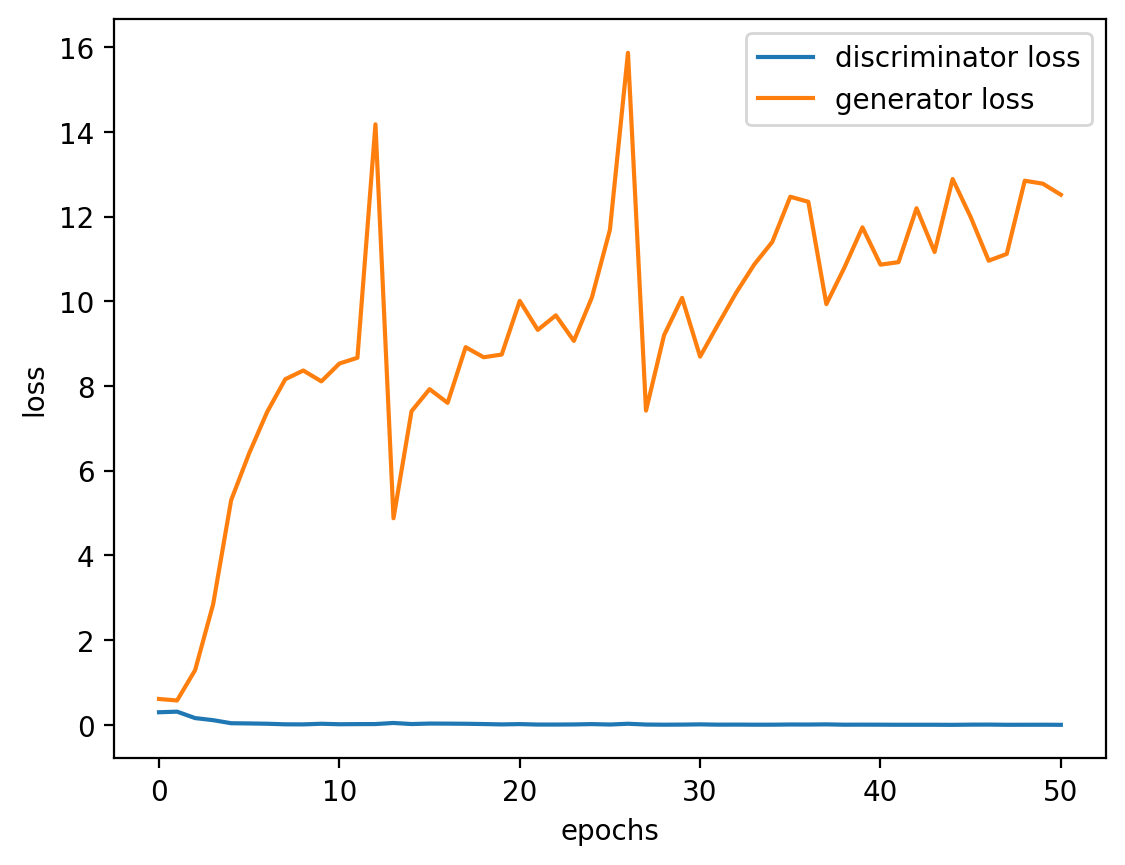

In [171]:
from matplotlib import pyplot as plt
avg_d_loss_m = [np.mean(x) for x in classic_d_loss_m]
avg_g_loss_m = [np.mean(x) for x in classic_g_loss_m]
plt.plot(avg_d_loss_m)
plt.plot(avg_g_loss_m)
plt.legend(['discriminator loss','generator loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

## Plotting loss for a particular batch

Text(0, 0.5, 'loss')

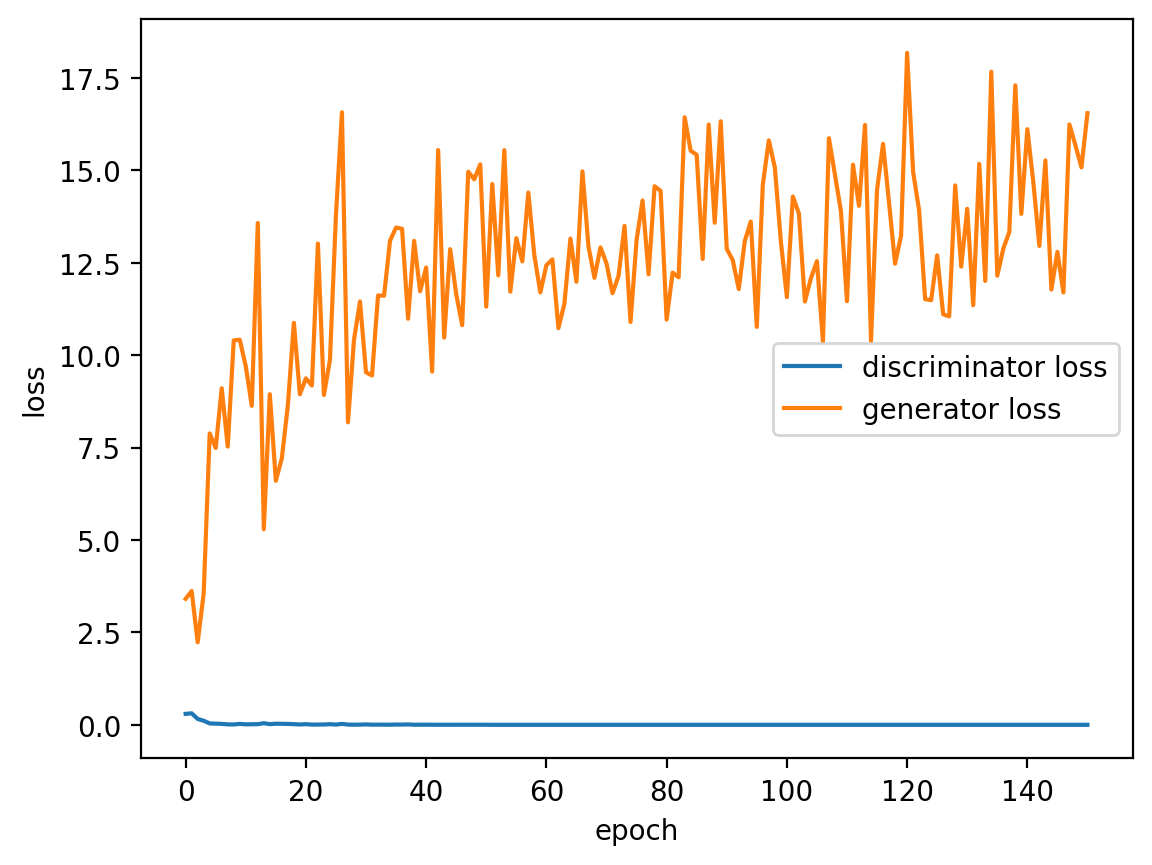

In [167]:
from matplotlib import pyplot as plt
import numpy as np
avg_d_loss_m = [np.mean(x) for x in classic_d_loss_m[1]]
avg_g_loss_m = [np.mean(x) for x in classic_g_loss_m[1]]
plt.plot(avg_d_loss_m)
plt.plot(avg_g_loss_m)
plt.legend(['discriminator loss','generator loss'])
plt.xlabel("batch")
plt.ylabel("loss")

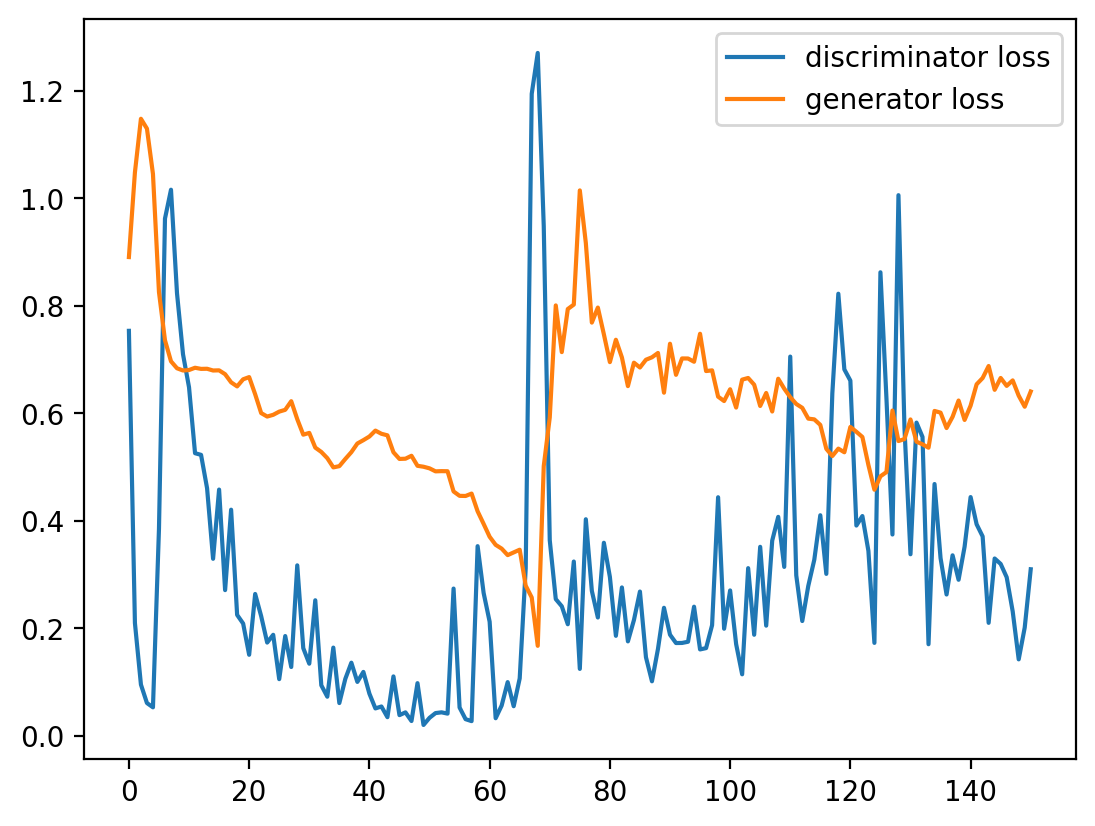

In [103]:
plt.plot(d_loss_m[0])
plt.plot(g_loss_m[0])
plt.legend(['discriminator loss','generator loss'])

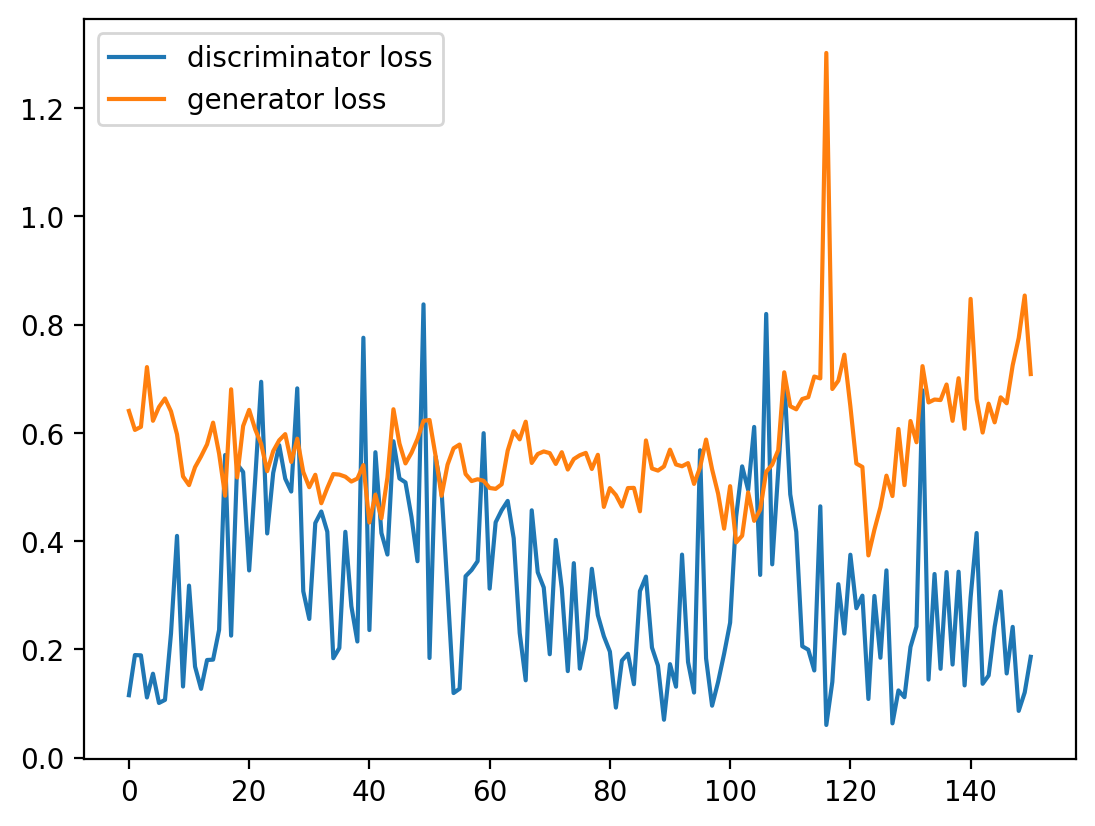

In [104]:
plt.plot(d_loss_m[1])
plt.plot(g_loss_m[1])
plt.legend(['discriminator loss','generator loss'])

## Using the trained generator to generate new images

In [181]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


# load model
model = g_model
# generate images
latent_points = generate_latent_points(latent_dim,1)
# generate images
X = g_model.predict(latent_points)

array = np.array(X.reshape(106,106),dtype = np.uint8)
array*= 255
new_image = Image.fromarray(array,'L')
new_image = new_image.save('classic2_composition.png')

1/1 [==============================] - 0s 443ms/step


## Function to take the generated image and convert it back to a playable MIDI format

In [199]:
from music21 import instrument, note, chord, stream
lowerBoundNote = 21
def column2notes(column):
    notes = []
    for i in range(len(column)):
        if column[i] > 255/2:
            notes.append(i+lowerBoundNote)
    return notes

resolution = 0.25
def updateNotes(newNotes,prevNotes): 
    res = {} 
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res
def image2midi(image_path):
    with Image.open(image_path) as image:
        im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
        try:
            print(image.size[1], image.size[0])
            im_arr = im_arr.reshape((image.size[1], image.size[0]))
        except:
            im_arr = im_arr.reshape((image.size[1], image.size[0],3))
            im_arr = np.dot(im_arr, [0.33, 0.33, 0.33])

    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model

    prev_notes = updateNotes(im_arr.T[0,:],{})
    for column in im_arr.T[1:,:]:
        notes = column2notes(column)
        # pattern is a chord
        notes_in_chord = notes
        old_notes = prev_notes.keys()
        for old_note in old_notes:
            if not old_note in notes_in_chord:
                new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                new_note.storedInstrument = instrument.Piano()
                if offset - prev_notes[old_note] >= 0:
                    new_note.offset = offset - prev_notes[old_note]
                    output_notes.append(new_note)
                elif offset == 0:
                    new_note.offset = offset
                    output_notes.append(new_note)                    
                else:
                    print(offset,prev_notes[old_note],old_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes)

        # increase offset each iteration so that notes do not stack
        offset += resolution

    for old_note in prev_notes.keys():
        new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset - prev_notes[old_note]

        output_notes.append(new_note)

    prev_notes = updateNotes(notes_in_chord,prev_notes)

    midi_stream = stream.Stream(output_notes)
    
    name = image_path
    name = name.replace(".png",".mid")
    name = name.split('\\')[1]
    print(name)
    print('synth_midis\\' + name)

    midi_stream.write('midi', 'ost_synth_comp\\' + name)
    # midi_stream.write('midi', 'wha3.mid')

In [109]:
g_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 359552)            36314752  
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 359552)            0         
                                                                 
 reshape_2 (Reshape)         (None, 53, 53, 128)       0         
                                                                 
 dense_11 (Dense)            (None, 53, 53, 1024)      132096    
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 106, 106, 1024)   16778240  
 ranspose)                                                       
                                                                 
 dense_12 (Dense)            (None, 106, 106, 1024)    1049600   
                                                      

## Generating multiple images using the trained generator

In [198]:
latent_dim = 100
for i in range(5):
    latent_points = generate_latent_points(latent_dim,1)

    X = ost_g_model.predict(latent_points)

    array = np.array(X.reshape(106,106),dtype = np.uint8)
    array*= 255
    new_image = Image.fromarray(array,'L')
    new_image = new_image.save('ost_synth_comp\\{}_composition.png'.format(i))

1/1 [==============================] - 0s 176ms/step


## Converting the generated images to playable format

In [200]:
for i in range(5):
    image2midi('ost_synth_comp\\{}_composition.png'.format(i))

C:\Users\Heinz\AppData\Local\Temp\ipykernel_23228\1486244596.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)


106 106
0_composition.mid
synth_midis\0_composition.mid
106 106
1_composition.mid
synth_midis\1_composition.mid
106 106
2_composition.mid
synth_midis\2_composition.mid
106 106
3_composition.mid
synth_midis\3_composition.mid
106 106
4_composition.mid
synth_midis\4_composition.mid


# ConvLSTM , defining the model

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu'), input_shape=(None, 9, 106)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2, strides=None)))
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2, strides=None)))
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2, strides=None)))
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu')))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(128,return_sequences = True))
model.add(LSTM(64))
model.add(BatchNormalization())
model.add(Dense(106,activation = 'sigmoid'))
model.compile(optimizer='adam', loss='mse')

## Preparing the data to fit the LSTM model, we use the original dataset thus no loading/preparing data required

In [ ]:
def split_sequences(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix-1], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
X = []
y = []
for i in range(len(pixels)):
    mini_x,mini_y = split_sequences(pixels[i],10)
    X.append(mini_x)
    y.append(mini_y)
X = np.array(X)
y = np.array(y)
X = X.reshape(len(X),1,9,106)
y = y.reshape((y.shape[0]*y.shape[1],y.shape[2]))

## Defining checkpoint for model, to save weight of the model on each epoch

In [ ]:
filepath = "beeth-weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     

## Training the model 

In [ ]:
model.fit(X,y, epochs=200, batch_size=64, callbacks=callbacks_list)

Text(0, 0.5, 'loss')

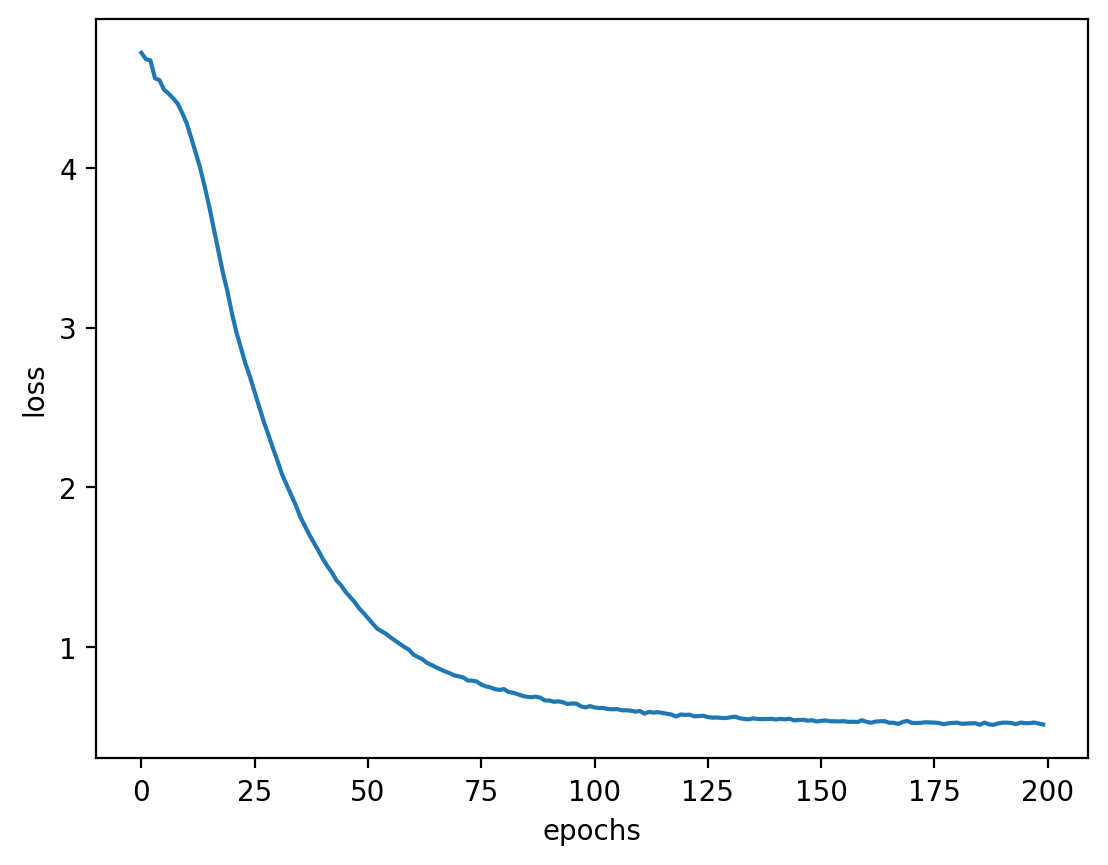

In [175]:
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('loss')

## Using the trained model to generate new images

In [ ]:
song_length = 106
data = X[np.random.randint(len(X))][0]
song = []
for i in range(song_length):
    pred = model.predict(data.reshape(1,1,9,106))[0]
    notes = (pred.astype(np.uint8)).reshape(106)
    print(notes)
    song.append(notes)
    data = list(data)
    data.append(notes)
    data.pop(0)
    data = np.array(data)

In [ ]:
new_image = Image.fromarray(np.array(song))
new_image.save('lstm_composition.png')

## Converting images back to playable format using the previous functions

In [ ]:
image2midi('lstm_composition.png')